## Introduction to ANN - Exercise
---
Instructions are given in <span style="color:blue">blue</span> color.

Here, there really is just one task: Repeat the training part of the notebook we used in class replacing the MNIST dataset with [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html), but also do some experimentation with the MLP-Parameters:
* $n_h$: number of hidden layers,
* $m_j,\>j=1,\dots,n_h$: number of neurons in the $j$-th hidden layer,
* and other hyperparameters that have an impact on performance and training time.

### CIFAR-10

The CIFAR-10 dataset consists of $32 \times 32 \times 3$ RGB pixel images, where each pixel is represented by a RGB value. The third dimension (or *channel* in the case of image data) represents the color value. Therefore, we have $32\times32\times3=3072$ *features* per row. The images are then *unrolled* (or flattened) into vectors of length $3072$ and each one (in both the training set and the test set) is given a *class label* of $0-9$ corresponding to the type of class it represents (where the number corresponds to the alphabetic ordering of the classes).

You fill find the dataset publicly available on [Alex Krizhevsky's Homepage](https://www.cs.toronto.edu/~kriz/cifar.html). To load the data you can use an *adaptation* of the following code from [Matt Petersen](https://mattpetersen.github.io/load-cifar10-with-numpy). Either specify a path and the data will automatically be downloaded, or download the binary version of the data beforehand.
This is done with the following code along with some restructuring in order to be able to work with the data in very much the same way we did with MNIST in class.

**Note**: It might actually take a while to execute the next couple of code cells, especially if the data needs to be downloaded first. Just be patient.

In [1]:
"""Load from /home/USER/data/cifar10 or elsewhere; download if missing."""

import tarfile
import os
from urllib.request import urlretrieve
import numpy as np


def cifar10(path=None):
    r"""Return (train_images, train_labels, test_images, test_labels).

    Args:
        path (str): Directory containing CIFAR-10. Default is
            /home/USER/data/cifar10 or C:\Users\USER\data\cifar10.
            Create if nonexistant. Download CIFAR-10 if missing.

    Returns:
        Tuple of (train_images, train_labels, test_images, test_labels), each
            a matrix. Rows are examples. Columns of images are pixel values,
            with the order (red -> blue -> green). Columns of labels are a
            onehot encoding of the correct class.
    """
    url = 'https://www.cs.toronto.edu/~kriz/'
    tar = 'cifar-10-binary.tar.gz'
    files = ['cifar-10-batches-bin/data_batch_1.bin',
             'cifar-10-batches-bin/data_batch_2.bin',
             'cifar-10-batches-bin/data_batch_3.bin',
             'cifar-10-batches-bin/data_batch_4.bin',
             'cifar-10-batches-bin/data_batch_5.bin',
             'cifar-10-batches-bin/test_batch.bin']

    if path is None:
        # Set path to /home/USER/data/cifar10 or C:\Users\USER\data\cifar10
        path = os.path.join(os.path.expanduser('~'), 'data', 'cifar10')

    # Create path if it doesn't exist
    os.makedirs(path, exist_ok=True)

    # Download tarfile if missing
    if tar not in os.listdir(path):
        urlretrieve(''.join((url, tar)), os.path.join(path, tar))
        print("Downloaded %s to %s" % (tar, path))

    # Load data from tarfile
    with tarfile.open(os.path.join(path, tar)) as tar_object:
        # Each file contains 10,000 color images and 10,000 labels
        fsize = 10000 * (32 * 32 * 3) + 10000

        # There are 6 files (5 train and 1 test)
        buffr = np.zeros(fsize * 6, dtype='uint8')

        # Get members of tar corresponding to data files
        # -- The tar contains README's and other extraneous stuff
        members = [file for file in tar_object if file.name in files]

        # Sort those members by name
        # -- Ensures we load train data in the proper order
        # -- Ensures that test data is the last file in the list
        members.sort(key=lambda member: member.name)

        # Extract data from members
        for i, member in enumerate(members):
            # Get member as a file object
            f = tar_object.extractfile(member)
            # Read bytes from that file object into buffr
            buffr[i * fsize:(i + 1) * fsize] = np.frombuffer(f.read(), 'B')

    # Parse data from buffer
    # -- Examples are in chunks of 3,073 bytes
    # -- First byte of each chunk is the label
    # -- Next 32 * 32 * 3 = 3,072 bytes are its corresponding image

    # Labels are the first byte of every chunk
    labels = buffr[::3073]

    # Pixels are everything remaining after we delete the labels
    pixels = np.delete(buffr, np.arange(0, buffr.size, 3073))
    images = pixels.reshape(-1, 3072).astype('float32') / 255

    # Split into train and test
    train_images, test_images = images[:50000], images[50000:]
    train_labels, test_labels = labels[:50000], labels[50000:]

    return train_images, train_labels, test_images, test_labels

In [2]:
X_train, y_train, X_test, y_test = cifar10('./data')
print(f'Train - Rows: {X_train.shape[0]}, columns: {X_train.shape[1]}')
print(f'Test - Rows: {X_test.shape[0]}, columns: {X_test.shape[1]}')

Downloaded cifar-10-binary.tar.gz to ./data
Train - Rows: 50000, columns: 3072
Test - Rows: 10000, columns: 3072


The CIFAR-10 data has a different structure than the MNIST data. To get the same structure as in the class example we need to switch some dimensions and reshape the array.

In [3]:
X_train = (np.moveaxis(X_train.reshape(50000,3,32,32),1,-1)).reshape(50000,3072)
X_test = (np.moveaxis(X_test.reshape(10000,3,32,32),1,-1)).reshape(10000,3072)

In [4]:
X_train.shape[1]

3072

To remove the color channel from our images we have to reshape a little differently.

In [5]:
# Calculating the mean of all 3 channels as the greyscale value:
X_train_g = np.mean(X_train.reshape(50000,32,32,3),-1).reshape(50000,1024)
X_test_g = np.mean(X_test.reshape(10000,32,32,3),-1).reshape(10000,1024)

In [6]:
X_train_g.shape[1]

1024

* <div style="color:blue">Let's get started with a little visualization task by displaying the 42nd image of each class present.</div>

**Hint**: Remember that you are working with an additional color dimension!

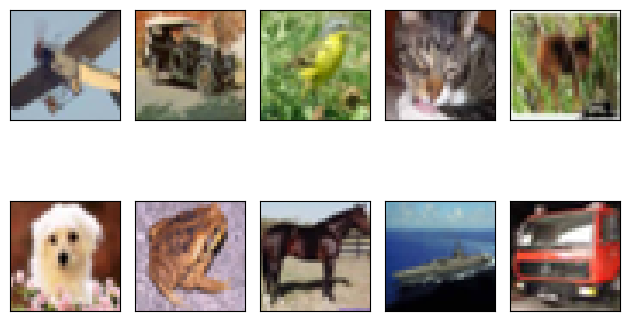

In [18]:
# Your solution goes here:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][42].reshape(32, 32, 3) 
    ax[i].imshow(img, interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

* <div style="color:blue">Visualize 25 different samples of the class representing dogs.</div>

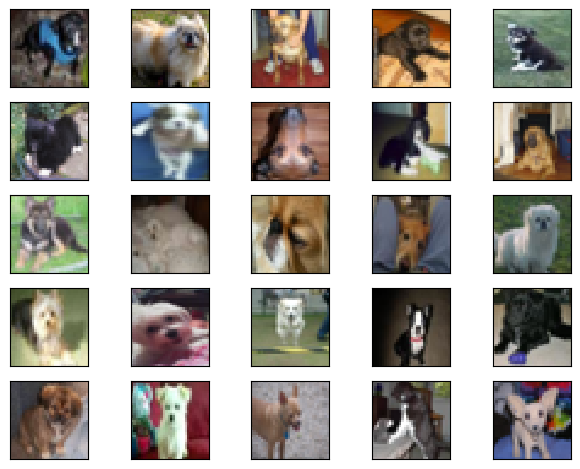

In [21]:
# Your solution goes here:
# Your solution goes here:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = X_train[y_train == 5][i].reshape(32, 32, 3) 
    ax[i].imshow(img, interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

You are now asked to perform image classification using a multi-layer perceptron:

* <div style="color:blue">Use <code>scikit learn</code>'s <code>MLPClassifier</code> to train various models that specify</div>

    * <div style="color:blue">different numbers of hidden layers,</div>
    * <div style="color:blue">different numbers of neurons in the hidden layers,</div>
    * <div style="color:blue">different hyperparameters (see info below).</div>
* <div style="color:blue">For each of your model variants you should record</div>

    * <div style="color:blue">the time it took to train the network,</div>
    * <div style="color:blue">how many epochs were necessary,</div>
    * <div style="color:blue">how the loss values evolved over the epochs,</div>
    * <div style="color:blue">the accuracy of both training and test data.</div>
* <div style="color:blue">What is your <b>interpretation</b> of those experiments? Give a comment on the behaviour of the different MLP configurations.</div>

**Hints**: 
* The CIFAR-10 data is much more complex than MNIST (as seen in class). The image resolution is very small and the classes are much more *nuanced*. In order to successfully classify such data, you might need to tune some parameters of your model.
* Due to the bigger input size, training times might be much slower than you have seen in class. You absolutely should change some hyperparameters that have an impact on the training times (if you don't want to wait for hours). Here are some **ideas** you could try: 
    + `batch_size`: Larger batch sizes mean less gradient updates are computed, but calculating the gradient is more computationally expensive. So there is an inherent trade-off in the magnitude of batch sizes. Not only that, but different batch sizes will have an impact on model performance. Increasing the batch size might lead to a solution that is closer to the true global minimum (which can actually be undesired as the model loses its ability to generalize). On the other hand, decreasing the batch size might get the model stuck at a bad local minimum early on in the training process. For further information see [Goodfellow et al., 2016](http://www.deeplearningbook.org/contents/optimization.html).
    + `learning_rate`: Higher learning rates will reduce the model's convergence time, but can result in suboptimal weight updates towards the end of the learning process (which can lead to increased bias of the model).
    + `hidden_layer_sizes`: Reducing the number of layers and neurons will result in a less complex model and, therefore, faster training times. However, if the model is too simple, it might not be able to fit the data at hand, which results in low accuracy.
    + `max_iter`: You can force an early stop of the training process with this parameter. This is actually a valid strategy to prevent overfitting, but the model might not fit the data yet if you stop too early. Don't be shy to try really low values!
    + **Data Transformation**: Sometimes it can make sense to transform the data to improve training time. You can always train with less data of course, but this might lead to poor performance of the model. For the image classification task, you can also try to train with *greyscale* only, which would reduce input size by 2/3. Maybe the model is mostly invariant to the *color component*?
<br>
<br>
* If you want to see some more information during the training process, you can turn on the `verbose` parameter (recommended!).
* Getting *above* 50% Test-Accuracy in a short amount of training time would be a really good result! Can you do it?

In [28]:
# Your solution goes here: (if you need more code/markdown cells, feel free to insert them as you see fit)
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier(hidden_layer_sizes=(100,100),
                   activation='logistic',
                   solver='sgd',
                   alpha=0.001,
                   batch_size=50,
                   learning_rate='constant',
                   learning_rate_init=0.05,
                   max_iter=10,
                   verbose=True,
                   random_state=1)

<div style="color:lightblue"> We define a Neural network with 2 hiden layers of size 100 and 100 each, using the Sigmoid activation funtion, with a batch size of 50, and learning rate of 0.05, and train it over 10 epocs

In [29]:

import datetime as dt

start = dt.datetime.now()
print(f'Starting training the model at {start:%H:%M:%S}')
nn.fit(X_train, y_train)
end = dt.datetime.now()
print(f'Done training the model at {end:%H:%M:%S}')

Starting training the model at 16:39:34
Iteration 1, loss = 1.95165569
Iteration 2, loss = 1.72389816
Iteration 3, loss = 1.65477370
Iteration 4, loss = 1.61793739
Iteration 5, loss = 1.59384162
Iteration 6, loss = 1.59466525
Iteration 7, loss = 1.58100978
Iteration 8, loss = 1.56970048
Iteration 9, loss = 1.57466301
Iteration 10, loss = 1.55803853
Done training the model at 16:40:23


c:\Users\smart\miniforge-pypy3\envs\dl4cv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


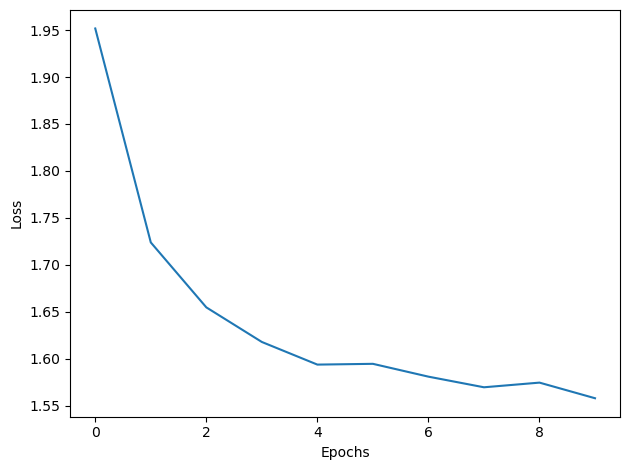

In [30]:
%matplotlib inline
loss_values = nn.loss_curve_
import matplotlib.pyplot as plt
plt.plot(range(len(loss_values)), loss_values)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

In [31]:
y_train_pred = nn.predict(X_train)

acc = np.sum(y_train == y_train_pred, axis=0) / X_train.shape[0]

print(f'Training accuracy: {(acc * 100):.2f}%')

Training accuracy: 41.75%


In [32]:
y_test_pred = nn.predict(X_test)

acc = np.sum(y_test == y_test_pred, axis=0) / X_test.shape[0]

print(f'Test accuracy: {(acc * 100):.2f}%')

Test accuracy: 40.06%


<div style="color:lightblue"> The training time was reasonable, but the over all accuracy is still below 50%, so the model is not very preformant, we can try a diffrent collection of parameters to see how better the model can get

In [37]:
nn = MLPClassifier(hidden_layer_sizes=(200,100,50),
                   activation='logistic',
                   solver='sgd',
                   alpha=0.001,
                   batch_size=100,
                   learning_rate='constant',
                   learning_rate_init=0.01,
                   max_iter=50,
                   verbose=True,
                   random_state=1)

import datetime as dt

start = dt.datetime.now()
print(f'Starting training the model at {start:%H:%M:%S}')
nn.fit(X_train, y_train)
end = dt.datetime.now()
print(f'Done training the model at {end:%H:%M:%S}')

Starting training the model at 16:47:36
Iteration 1, loss = 2.30677003
Iteration 2, loss = 2.30249644
Iteration 3, loss = 2.27600795
Iteration 4, loss = 2.12211064
Iteration 5, loss = 2.05977066
Iteration 6, loss = 2.04783797
Iteration 7, loss = 2.03727456
Iteration 8, loss = 2.02218976
Iteration 9, loss = 1.98931129
Iteration 10, loss = 1.91905463
Iteration 11, loss = 1.87015423
Iteration 12, loss = 1.84469966
Iteration 13, loss = 1.82254208
Iteration 14, loss = 1.79867764
Iteration 15, loss = 1.77649287
Iteration 16, loss = 1.75744917
Iteration 17, loss = 1.74159209
Iteration 18, loss = 1.72614526
Iteration 19, loss = 1.71063514
Iteration 20, loss = 1.69378004
Iteration 21, loss = 1.67699118
Iteration 22, loss = 1.65907035
Iteration 23, loss = 1.64437249
Iteration 24, loss = 1.62602452
Iteration 25, loss = 1.60779064
Iteration 26, loss = 1.58934313
Iteration 27, loss = 1.57339443
Iteration 28, loss = 1.55512442
Iteration 29, loss = 1.53942655
Iteration 30, loss = 1.52307790
Iteration

c:\Users\smart\miniforge-pypy3\envs\dl4cv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


In [39]:
y_train_pred = nn.predict(X_train)

acc = np.sum(y_train == y_train_pred, axis=0) / X_train.shape[0]

print(f'Training accuracy: {(acc * 100):.2f}%')

Training accuracy: 54.19%


In [40]:
y_test_pred = nn.predict(X_test)

acc = np.sum(y_test == y_test_pred, axis=0) / X_test.shape[0]

print(f'Test accuracy: {(acc * 100):.2f}%')

Test accuracy: 49.17%


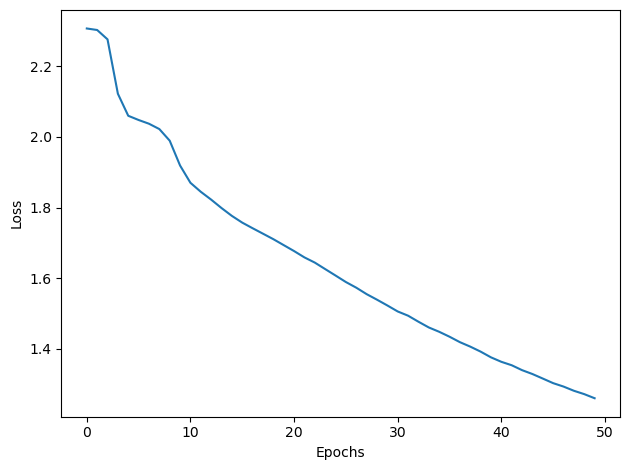

In [41]:
%matplotlib inline
loss_values = nn.loss_curve_
import matplotlib.pyplot as plt
plt.plot(range(len(loss_values)), loss_values)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

<div style="color:lightblue"> We got accuracy of around 50% for both training and test data, and as we see in the loss over epoch graph, it is showing that the more epochs, the lower the loss, so maybe we can try the retraining but with more epochs this time.

In [42]:
nn = MLPClassifier(hidden_layer_sizes=(200,100,50),
                   activation='logistic',
                   solver='sgd',
                   alpha=0.001,
                   batch_size=100,
                   learning_rate='constant',
                   learning_rate_init=0.01,
                   max_iter=500,
                   verbose=True,
                   random_state=1)

import datetime as dt

start = dt.datetime.now()
print(f'Starting training the model at {start:%H:%M:%S}')
nn.fit(X_train, y_train)
end = dt.datetime.now()
print(f'Done training the model at {end:%H:%M:%S}')

Starting training the model at 17:07:47
Iteration 1, loss = 2.30677003
Iteration 2, loss = 2.30249644
Iteration 3, loss = 2.27600795
Iteration 4, loss = 2.12211064
Iteration 5, loss = 2.05977066
Iteration 6, loss = 2.04783797
Iteration 7, loss = 2.03727456
Iteration 8, loss = 2.02218976
Iteration 9, loss = 1.98931129
Iteration 10, loss = 1.91905463
Iteration 11, loss = 1.87015423
Iteration 12, loss = 1.84469966
Iteration 13, loss = 1.82254208
Iteration 14, loss = 1.79867764
Iteration 15, loss = 1.77649287
Iteration 16, loss = 1.75744917
Iteration 17, loss = 1.74159209
Iteration 18, loss = 1.72614526
Iteration 19, loss = 1.71063514
Iteration 20, loss = 1.69378004
Iteration 21, loss = 1.67699118
Iteration 22, loss = 1.65907035
Iteration 23, loss = 1.64437249
Iteration 24, loss = 1.62602452
Iteration 25, loss = 1.60779064
Iteration 26, loss = 1.58934313
Iteration 27, loss = 1.57339443
Iteration 28, loss = 1.55512442
Iteration 29, loss = 1.53942655
Iteration 30, loss = 1.52307790
Iteration

In [43]:
y_train_pred = nn.predict(X_train)

acc = np.sum(y_train == y_train_pred, axis=0) / X_train.shape[0]

print(f'Training accuracy: {(acc * 100):.2f}%')

Training accuracy: 96.30%


In [44]:
y_test_pred = nn.predict(X_test)

acc = np.sum(y_test == y_test_pred, axis=0) / X_test.shape[0]

print(f'Test accuracy: {(acc * 100):.2f}%')

Test accuracy: 48.20%


<div style="color:lightblue"> after increasing the number of epochs for the model, the accuracy of the test data increase quite a bit, but after testing on the test data, we can se that the model is overfit. Therfore increasing the number of epochs does not always improve overall accuracy and could lead to overfitting.

In [48]:
nn = MLPClassifier(hidden_layer_sizes=(100,30),
                   activation='logistic',
                   solver='sgd',
                   alpha=0.001,
                   batch_size=25,
                   learning_rate='constant',
                   learning_rate_init=0.005,
                   max_iter=50,
                   tol=0.001,
                   verbose=True,
                   random_state=1)

import datetime as dt

start = dt.datetime.now()
print(f'Starting training the model at {start:%H:%M:%S}')
nn.fit(X_train, y_train)
end = dt.datetime.now()
print(f'Done training the model at {end:%H:%M:%S}')

Starting training the model at 08:40:36
Iteration 1, loss = 2.15473297
Iteration 2, loss = 1.93173419
Iteration 3, loss = 1.83625772
Iteration 4, loss = 1.76647540
Iteration 5, loss = 1.71202406
Iteration 6, loss = 1.66744680
Iteration 7, loss = 1.62810549
Iteration 8, loss = 1.59482640
Iteration 9, loss = 1.56442492
Iteration 10, loss = 1.53730621
Iteration 11, loss = 1.51223174
Iteration 12, loss = 1.48968881
Iteration 13, loss = 1.46839355
Iteration 14, loss = 1.45036277
Iteration 15, loss = 1.43356352
Iteration 16, loss = 1.41605844
Iteration 17, loss = 1.40033920
Iteration 18, loss = 1.38627805
Iteration 19, loss = 1.37109262
Iteration 20, loss = 1.35862129
Iteration 21, loss = 1.34632329
Iteration 22, loss = 1.33292753
Iteration 23, loss = 1.32229023
Iteration 24, loss = 1.31009825
Iteration 25, loss = 1.30224342
Iteration 26, loss = 1.29168590
Iteration 27, loss = 1.28232087
Iteration 28, loss = 1.27349609
Iteration 29, loss = 1.26216616
Iteration 30, loss = 1.25619753
Iteration

c:\Users\smart\miniforge-pypy3\envs\dl4cv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


In [49]:
y_train_pred = nn.predict(X_train)

acc = np.sum(y_train == y_train_pred, axis=0) / X_train.shape[0]

print(f'Training accuracy: {(acc * 100):.2f}%')

Training accuracy: 62.80%


In [50]:
y_test_pred = nn.predict(X_test)

acc = np.sum(y_test == y_test_pred, axis=0) / X_test.shape[0]

print(f'Test accuracy: {(acc * 100):.2f}%')

Test accuracy: 51.90%


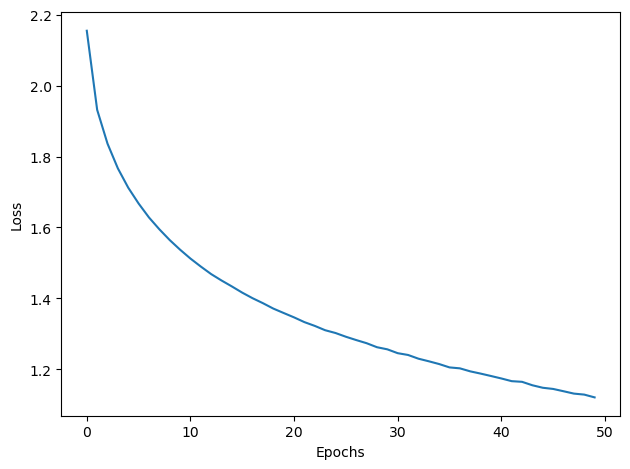

In [51]:
%matplotlib inline
loss_values = nn.loss_curve_
import matplotlib.pyplot as plt
plt.plot(range(len(loss_values)), loss_values)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

<div style=color:lightblue> By changing around values and having a reasnable number of epochs (50), we were able to achieve around 60% accuracy on training data and 50% accuracy on test data.

In [94]:
nn = MLPClassifier(hidden_layer_sizes=(500),
                   activation='relu',
                   solver='sgd',
                   alpha=0.001,
                   batch_size=750,
                   learning_rate='constant',
                   learning_rate_init=0.02,
                   max_iter=25,
                   tol=0.001,
                   verbose=True,
                   random_state=1)

import datetime as dt

start = dt.datetime.now()
print(f'Starting training the model at {start:%H:%M:%S}')
nn.fit(X_train, y_train)
end = dt.datetime.now()
print(f'Done training the model at {end:%H:%M:%S}')

Starting training the model at 09:21:48
Iteration 1, loss = 1.97550945
Iteration 2, loss = 1.73376815
Iteration 3, loss = 1.65263461
Iteration 4, loss = 1.59676675
Iteration 5, loss = 1.55293346
Iteration 6, loss = 1.52362834
Iteration 7, loss = 1.49499100
Iteration 8, loss = 1.46432716
Iteration 9, loss = 1.44049209
Iteration 10, loss = 1.42384187
Iteration 11, loss = 1.39868389
Iteration 12, loss = 1.38019095
Iteration 13, loss = 1.36656983
Iteration 14, loss = 1.34615350
Iteration 15, loss = 1.33108181
Iteration 16, loss = 1.32317908
Iteration 17, loss = 1.30523037
Iteration 18, loss = 1.28450858
Iteration 19, loss = 1.27427781
Iteration 20, loss = 1.27189516
Iteration 21, loss = 1.27273872
Iteration 22, loss = 1.24748634
Iteration 23, loss = 1.22334494
Iteration 24, loss = 1.22113666
Iteration 25, loss = 1.21336357
Done training the model at 09:23:15


c:\Users\smart\miniforge-pypy3\envs\dl4cv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


In [95]:
y_train_pred = nn.predict(X_train)

acc = np.sum(y_train == y_train_pred, axis=0) / X_train.shape[0]

print(f'Training accuracy: {(acc * 100):.2f}%')

Training accuracy: 57.15%


In [96]:
y_test_pred = nn.predict(X_test)

acc = np.sum(y_test == y_test_pred, axis=0) / X_test.shape[0]

print(f'Test accuracy: {(acc * 100):.2f}%')

Test accuracy: 50.16%


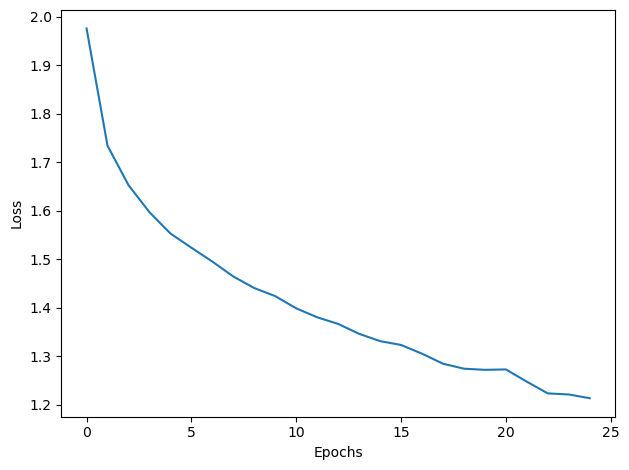

In [97]:
%matplotlib inline
loss_values = nn.loss_curve_
import matplotlib.pyplot as plt
plt.plot(range(len(loss_values)), loss_values)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

<div style="color:lightblue"> After messing around with values for a while i was able to acheive aobuve 50% accuracy in around 1.5 minutes, i found out:<br>
-Having one large hidden layers of size x was better than having two layers of size x/2 if all other parameters were the same.<br>
-relu seemed to be better at avoiding overfitign thatn sigmoid


In [143]:
nn = MLPClassifier(hidden_layer_sizes=(500),
                   activation='relu',
                   solver='sgd',
                   alpha=0.001,
                   batch_size=750,
                   learning_rate='constant',
                   learning_rate_init=0.01,
                   max_iter=100,
                   tol=0.001,
                   verbose=True,
                   random_state=1)

import datetime as dt

start = dt.datetime.now()
print(f'Starting training the model at {start:%H:%M:%S}')
nn.fit(X_train, y_train)
end = dt.datetime.now()
print(f'Done training the model at {end:%H:%M:%S}')

Starting training the model at 15:18:58


Iteration 1, loss = 1.96388977
Iteration 2, loss = 1.76998383
Iteration 3, loss = 1.69884648
Iteration 4, loss = 1.64920160
Iteration 5, loss = 1.60780003
Iteration 6, loss = 1.57530878
Iteration 7, loss = 1.54777465
Iteration 8, loss = 1.52080402
Iteration 9, loss = 1.49908093
Iteration 10, loss = 1.47983175
Iteration 11, loss = 1.45832797
Iteration 12, loss = 1.43940239
Iteration 13, loss = 1.42546781
Iteration 14, loss = 1.40747285
Iteration 15, loss = 1.39246902
Iteration 16, loss = 1.37731481
Iteration 17, loss = 1.36291939
Iteration 18, loss = 1.34846706
Iteration 19, loss = 1.33626467
Iteration 20, loss = 1.32796199
Iteration 21, loss = 1.31279478
Iteration 22, loss = 1.30662827
Iteration 23, loss = 1.29025781
Iteration 24, loss = 1.28062368
Iteration 25, loss = 1.27216802
Iteration 26, loss = 1.26162487
Iteration 27, loss = 1.24865298
Iteration 28, loss = 1.24201728
Iteration 29, loss = 1.22994361
Iteration 30, loss = 1.22193960
Iteration 31, loss = 1.21316021
Iteration 32, los

c:\Users\smart\miniforge-pypy3\envs\dl4cv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [144]:
y_train_pred = nn.predict(X_train)

acc = np.sum(y_train == y_train_pred, axis=0) / X_train.shape[0]

print(f'Training accuracy: {(acc * 100):.2f}%')

Training accuracy: 74.71%


In [145]:
y_test_pred = nn.predict(X_test)

acc = np.sum(y_test == y_test_pred, axis=0) / X_test.shape[0]

print(f'Test accuracy: {(acc * 100):.2f}%')

Test accuracy: 53.24%


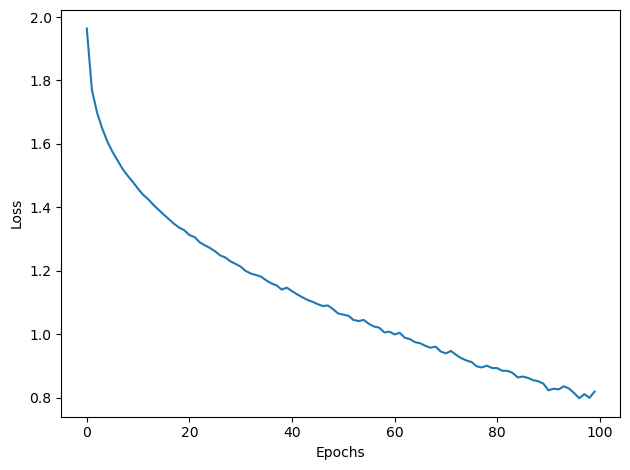

In [146]:
%matplotlib inline
loss_values = nn.loss_curve_
import matplotlib.pyplot as plt
plt.plot(range(len(loss_values)), loss_values)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

<div style="color:lightblue"> we increased the epochs but decrease the learning rate for this model, but kept everything else the same, and there was a significant increase in training data accuracy, but a small increae in the test accuracy, this idicates that as we increase the epochs, the model tends to overfit

* <div style="color:blue">Visualize 12 misclassifications <b>and</b> state an opinion on these.</div>

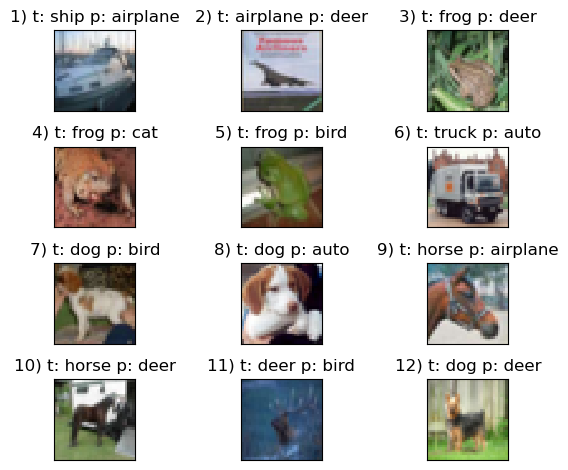

In [147]:
# Your solution goes here: (if you need more code/markdown cells, feel free to insert them as you see fit)
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab= y_test_pred[y_test != y_test_pred][:25]

test_lab_dict = {0:"airplane",1:"auto",2:"bird",3:"cat",4:"deer",5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}

fig, ax = plt.subplots(nrows=4, ncols=3, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(12):
    img = miscl_img[i].reshape(32, 32, 3)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %s p: %s' % (i+1, test_lab_dict[correct_lab[i]], test_lab_dict[miscl_lab[i]]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('./Images/mnist_miscl.png', dpi=300)
plt.show()

<div style="color:lightblue"> Some of the misclassifications are reasnable, such as 1, 2, and 11, where a human would struggle to classify these images, but the rest are quite easy for a huyman to recognise, so maybe there would be a need for a better model or an increase number of epocs and/or nodes for a more sophisticated model to be able to classify the images